In [1]:
import sys
sys.path.append('/Users/ikumakiyoshi/Library/Mobile Documents/com~apple~CloudDocs/study_fg_rm/program/Deltamap_test/Python_delta_map/function')
import noise_make as ns
import fg_make_file as fg
import cmb_make_file as cmb
import noise_make as ns
import alpha_Delta_map as dm
import healpy as hp
import numpy as np
from scipy.optimize import minimize
from numpy.linalg import solve as bslash

Using CAMB 1.5.2 installed at /Users/ikumakiyoshi/.julia/conda/3/lib/python3.10/site-packages/camb


###　共分散行列計算

In [2]:
nside = 4
random_seed_cmb = 5123
seed_syn = 5123

W, X = dm.Cal_sYlm(nside)
cl_scal, cl_lens, cl_tens = cmb.cmb_cell_make(nside, random_seed_cmb, seed_syn)
cl_scal = cl_scal + cl_lens

cl_scal = cl_scal.T
cl_tens = cl_tens.T

### ここの計算が重たい(これあってる？？？)

In [3]:
# TT, EE, BB, TE
cov_mat_scal = dm.Cal_cov(W, X, cl_scal[1], cl_scal[2])
cov_mat_tens = dm.Cal_cov(W, X, cl_tens[1], cl_tens[2])

/Users/ikumakiyoshi/Library/Mobile Documents/com~apple~CloudDocs/study_fg_rm/program/Deltamap_test/Python_delta_map/function/alpha_Delta_map.py:413: ComplexWarning: Casting complex values to real discards the imaginary part
  C[0:npix, 0:npix] = C_QQ
/Users/ikumakiyoshi/Library/Mobile Documents/com~apple~CloudDocs/study_fg_rm/program/Deltamap_test/Python_delta_map/function/alpha_Delta_map.py:414: ComplexWarning: Casting complex values to real discards the imaginary part
  C[0:npix, npix:2*npix] = C_QU
/Users/ikumakiyoshi/Library/Mobile Documents/com~apple~CloudDocs/study_fg_rm/program/Deltamap_test/Python_delta_map/function/alpha_Delta_map.py:415: ComplexWarning: Casting complex values to real discards the imaginary part
  C[npix:2*npix, 0:npix] = C_UQ
/Users/ikumakiyoshi/Library/Mobile Documents/com~apple~CloudDocs/study_fg_rm/program/Deltamap_test/Python_delta_map/function/alpha_Delta_map.py:416: ComplexWarning: Casting complex values to real discards the imaginary part
  C[npix:2*np

In [4]:
#np.save("cov_scal_nside_4", cov_mat_scal)
#np.save("cov_tens_nside_4", cov_mat_tens)

### noisde　作成

In [5]:
noise_seed = [1, 2, 3]
pol_sen = 0.2 # μK arcmin
noise_map, sigma = ns.noise_calc_simle(pol_sen, nside, noise_seed)

In [6]:
N_pix = hp.nside2npix(nside)
N_cov = np.identity(2 * N_pix) * sigma**2

In [56]:
random_seed_cmb = 5123
seed_syn = 5123

r = 0.01
N_pix = hp.nside2npix(nside)

cmb_map = cmb.cmb_make_file(nside, r, random_seed_cmb, seed_syn);

In [60]:
freq_band = [40, 50, 140]
cmb_freq = 140
freq_bs, freq_bd, beta_d, T_d = 23*10**9, 353*10**9, 1.5, 20.1

Q_1, U_1, x = dm.calc_x_pra(freq_band, cmb_freq, nside, cmb_map, "s1", freq_bs, -3., freq_bd, beta_d, T_d)

In [9]:
#r= 0.01
cov_mat = dm.Cal_cov_mat(cov_mat_scal, cov_mat_tens, r) + N_cov

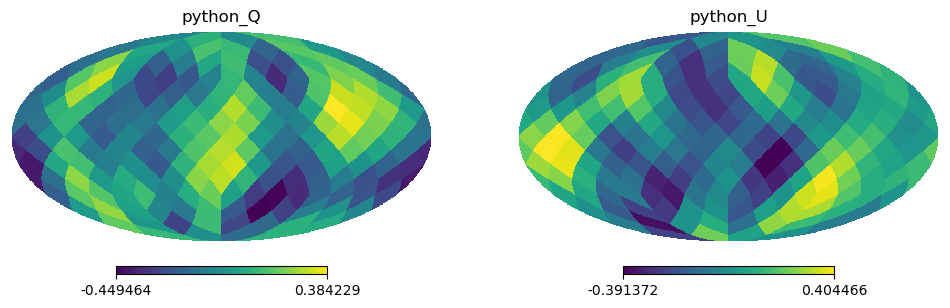

In [80]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

plt.axes(ax1)
hp.mollview(cmb_map[1], title="python_Q", hold=True)

plt.axes(ax2)
hp.mollview(cmb_map[2], title="python_U", hold=True)

### 行列式の確認

In [10]:
dm.log_det(cov_mat)

-4783.795338261841

In [11]:
#cov_mat

In [12]:
#sigma**2

In [13]:
#import numpy.linalg as LA
#det_C = LA.det(cov_mat)
#det_C
#log_det(cov_mat)

### パラメーター推定

In [14]:
#x.shape

In [15]:
noise_map_QU = np.concatenate([noise_map[0], noise_map[1]], 0)
#noise_map = np.concatenate([noise_map[0], noise_map[1]], 0)

In [16]:
#noise_map - noise_map_QU

In [61]:
x = x + noise_map_QU
#x = x + noise_map

In [18]:
#x - x_1

In [19]:
"""
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

plt.axes(ax1)
hp.mollview(-Q_1 + cmb_map[1], title="clean_map_Q", hold=True)

plt.axes(ax2)
hp.mollview(-U_1 + cmb_map[2], title="clean_map_U",hold=True)
"""

'\nimport healpy as hp\nimport numpy as np\nimport matplotlib.pyplot as plt\n\nfig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))\n\nplt.axes(ax1)\nhp.mollview(-Q_1 + cmb_map[1], title="clean_map_Q", hold=True)\n\nplt.axes(ax2)\nhp.mollview(-U_1 + cmb_map[2], title="clean_map_U",hold=True)\n'

In [20]:
#x - cov_mat @ bslash(cov_mat, x)

In [21]:
# 1番
from scipy.linalg import lu, solve
def inverse_matrix_lu(A):
    P, L, U = lu(A)
    A_inv = solve(U, solve(L, P.T))    
    return A_inv

In [22]:
# 3番目
def inverse_matrix_svd(A):
    U, S, Vt = np.linalg.svd(A, full_matrices=False)
    A_inv_svd = Vt.T @ np.linalg.inv(np.diag(S)) @ U.T
    return A_inv_svd

In [23]:
# 2番目
def inverse_matrix_qr(A):
    Q, R = np.linalg.qr(A)
    A_inv_qr = np.linalg.inv(R) @ Q.T
    return A_inv_qr

In [24]:
#　普通
def inverse_matrix_block(A, block_size=100000):
    n = A.shape[0]
    A_inv_block = np.zeros_like(A)

    for i in range(0, n, block_size):
        block_end = min(i + block_size, n)
        A_inv_block[i:block_end, i:block_end] = np.linalg.inv(A[i:block_end, i:block_end])

    return A_inv_block

In [25]:
#x - cov_mat @ inverse_matrix_lu(cov_mat) @ x

In [26]:
#x - cov_mat @ inverse_matrix_svd(cov_mat) @ x

In [27]:
#- cov_mat @ inverse_matrix_qr(cov_mat) @ x

In [28]:
#x - cov_mat @ inverse_matrix_block(cov_mat) @ x

In [29]:
"""
def is_symmetric(matrix):
    # Check if a matrix is symmetric
    return np.array_equal(matrix, matrix.T)
    """

'\ndef is_symmetric(matrix):\n    # Check if a matrix is symmetric\n    return np.array_equal(matrix, matrix.T)\n    '

In [30]:
#inverse_result = calculate_high_precision_inverse_matrix(cov_mat, precision=20)

In [31]:
#inverse_result @ cov_mat

### juliaのために保存 cov_mat, x

In [32]:
#np.save('cov_mat.npy', cov_mat)
#np.save('x.npy', x)

In [33]:
# 対称行列かの判断
#is_symmetric(cov_mat)

In [34]:
#from numpy.linalg import solve as bslash
#like = x.T @ bslash(cov_mat, x)

In [35]:
#like

In [36]:
#np.save('like.npy', like)

### for ループで最小

In [52]:
r_in = np.arange(0, 1, 10**-3)

In [68]:
xx = np.block([cmb_map[1], cmb_map[2]])

In [73]:
xx @ bslash(cov_mat, xx)

45.88893998780567

In [75]:
dm.log_det(cov_mat)

-4274.330890435433

In [78]:
#np.save("xx_py", xx)
#np.save("cov_mat_py", cov_mat)

In [70]:
import math
from numpy.linalg import solve as bslash

like_array = []

for r_pre in r_in:
    
    cov_mat = dm.Cal_cov_mat(cov_mat_scal, cov_mat_tens, r_pre) + N_cov

    det_C = dm.log_det(cov_mat)
    
    #like_array.append(x @ bslash(cov_mat, x) + det_C)

    # input map
    like_array.append(xx @ bslash(cov_mat, xx) + det_C)

    #Q_1, U_1, x = dm.calc_x_pra(freq_band, cmb_freq, nside, cmb_map, "s1", freq_bs, beta_s, freq_bd, beta_d, T_d)
    
    #x = x + noise_map

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


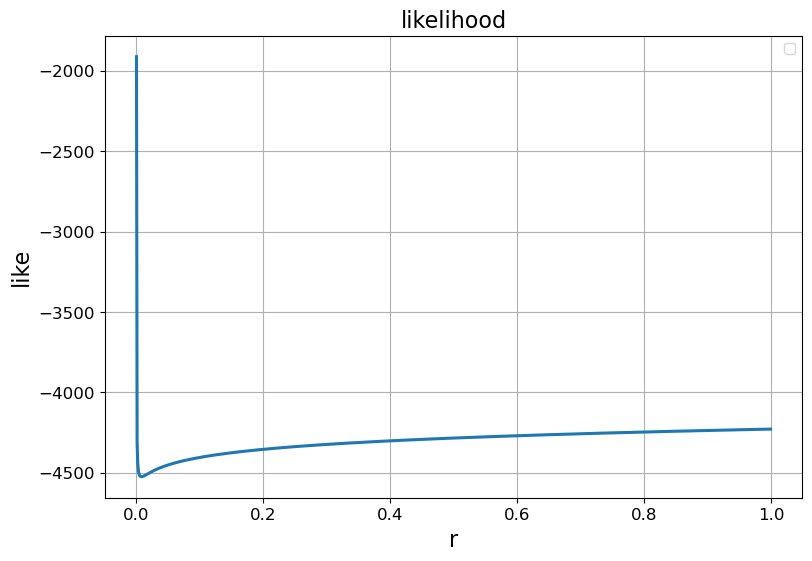

In [71]:
import matplotlib.pyplot as plt

#plot#
fig = plt.figure(figsize=(9, 6))

plt.plot(r_in, like_array , lw = 2.2)

plt.ylabel("like", fontsize=16)
plt.xlabel('r', fontsize=16)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.title("likelihood", fontsize=16)

plt.grid()
plt.legend()

plt.show()

In [72]:
r_in[np.argmin(like_array)]

0.008

In [41]:
#beta_in = np.arange(-5, -2, 0.1)

In [42]:
"""
import math

chi_sq_array = []
x_array = []

for beta_pre in beta_in:

    Q_1, U_1, x = dm.calc_x_pra(freq_band, cmb_freq, nside, cmb_map, "s1", freq_bs, beta_pre, freq_bd, beta_d, T_d)

    cov_mat = dm.Cal_cov_mat(cov_mat_scal, cov_mat_tens, r)+ N_cov

    det_C = dm.log_det(cov_mat)

    # chi sq
    chi_sq = x.T @ bslash(cov_mat, x)
    chi_sq_array.append(chi_sq)
    x_array.append(x)
    """

'\nimport math\n\nchi_sq_array = []\nx_array = []\n\nfor beta_pre in beta_in:\n\n    Q_1, U_1, x = dm.calc_x_pra(freq_band, cmb_freq, nside, cmb_map, "s1", freq_bs, beta_pre, freq_bd, beta_d, T_d)\n\n    cov_mat = dm.Cal_cov_mat(cov_mat_scal, cov_mat_tens, r)+ N_cov\n\n    det_C = dm.log_det(cov_mat)\n\n    # chi sq\n    chi_sq = x.T @ bslash(cov_mat, x)\n    chi_sq_array.append(chi_sq)\n    x_array.append(x)\n    '

In [43]:
"""
import matplotlib.pyplot as plt

#plot#
fig = plt.figure(figsize=(9, 6))

plt.plot(beta_in, chi_sq_array, lw = 2.2)
#plt.plot(beta_in, x_array , lw = 2.2)

plt.ylabel("chi_sq", fontsize=16)
plt.xlabel('beta', fontsize=16)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.title("chi_sq", fontsize=16)

plt.grid()
plt.legend()

plt.show()
"""

'\nimport matplotlib.pyplot as plt\n\n#plot#\nfig = plt.figure(figsize=(9, 6))\n\nplt.plot(beta_in, chi_sq_array, lw = 2.2)\n#plt.plot(beta_in, x_array , lw = 2.2)\n\nplt.ylabel("chi_sq", fontsize=16)\nplt.xlabel(\'beta\', fontsize=16)\n\nplt.xticks(fontsize=12)\nplt.yticks(fontsize=12)\n\nplt.title("chi_sq", fontsize=16)\n\nplt.grid()\nplt.legend()\n\nplt.show()\n'

In [44]:
#beta_in[np.argmin(chi_sq_array)]

### minimize関数で求める

In [45]:
# 最小化したい関数を定義する例
def minimize_function_chi_sq(beta_s, r):
    
    cov_mat = dm.Cal_cov_mat(cov_mat_scal, cov_mat_tens, r)+ N_cov

    Q_1, U_1, x = dm.calc_x_pra(freq_band, cmb_freq, nside, cmb_map, "s1", freq_bs, beta_s, freq_bd, beta_d, T_d)

    det_C = dm.log_det(cov_mat)

    #x = x + noise_map

    x = x + noise_map_QU
    
    return x @ bslash(cov_mat, x)

    
# 初期値を設定
beta_s = -3
r = 0.001

# minimize関数を使って最小化を行う
#result = minimize(minimize_function_chi_sq, initial_value, args = (r), bounds = [(-5., -2)],method='BFGS')
result = minimize(minimize_function_chi_sq, beta_s, args = (r), bounds = [(-4., -2)], method='COBYLA')

In [46]:
result
result.fun
result.x[0]

-3.0100539062499996

In [47]:
# 最小化したい関数を定義する例
def minimize_function_like(r, beta_s):
    
    cov_mat = dm.Cal_cov_mat(cov_mat_scal, cov_mat_tens, r)+ N_cov

    Q_1, U_1, x = dm.calc_x_pra(freq_band, cmb_freq, nside, cmb_map, "s1", freq_bs, beta_s, freq_bd, beta_d, T_d)

    det_C = dm.log_det(cov_mat)

    #x = x + noise_map

    x = x + noise_map_QU
    
    return x @ bslash(cov_mat, x) + det_C

# 初期値を設定
beta_s = -3.
r = 0.001

# minimize関数を使って最小化を行う
result = minimize(minimize_function_like, r, args = (beta_s), bounds = [(0., 1)], method='COBYLA')

/Users/ikumakiyoshi/Library/Mobile Documents/com~apple~CloudDocs/study_fg_rm/program/Deltamap_test/Python_delta_map/function/alpha_Delta_map.py:447: RuntimeWarning: invalid value encountered in log
  logdet = np.sum(np.log(np.linalg.eigvalsh(A)))


In [48]:
result.x[0]

0.001

### パラメータ推定

###　カイ二乗検定

In [49]:
# 最小化したい関数を定義する例
def minimize_function_chi_sq(beta_s, r):
    
    cov_mat = dm.Cal_cov_mat(cov_mat_scal, cov_mat_tens, r)+ N_cov

    Q_1, U_1, x = dm.calc_x_pra(freq_band, cmb_freq, nside, cmb_map, "s1", freq_bs, beta_s, freq_bd, beta_d, T_d)

    x = x + noise_map_QU
    
    return x @ bslash(cov_mat, x)

### Likelihood

In [50]:
# 最小化したい関数を定義する例
def minimize_function_like(r, beta_s):
    
    cov_mat = dm.Cal_cov_mat(cov_mat_scal, cov_mat_tens, r)+ N_cov

    Q_1, U_1, x = dm.calc_x_pra(freq_band, cmb_freq, nside, cmb_map, "s1", freq_bs, beta_s, freq_bd, beta_d, T_d)

    x = x + noise_map_QU
    
    det_C = dm.log_det(cov_mat)
    
    return x @ bslash(cov_mat, x) + det_C

In [51]:
num_iterations = 10

for iteration in range(num_iterations):

    if iteration == 0:

        # chi sq スペクトルパラメータ決定
        beta_pre = -3
        r_pre = 0.001

        # minimize関数
        #result = minimize(minimize_function_chi_sq, beta_pre, args = (r_pre), bounds = [(-5., -2)],method='BFGS')
        result_p = minimize(minimize_function_chi_sq, beta_pre, args = (r_pre), bounds = [(-5., -2)], method='COBYLA')

        print(f"Iteration {iteration + 1}: beta_s = {result_p.x[0]}")
        
        # スペクトルパラメータを更新
        beta_s_pre = result_p.x[0]
        r_pre = 0.001
        
        result_r = minimize(minimize_function_like, r_pre, args = (beta_s_pre), bounds = [(0., 1)], method='COBYLA')
    
        print(f"Iteration {iteration + 1}: r = {result_r.x[0]}")

    else:
        
        # chi sq スペクトルパラメータ決定
        beta_pre = result_p.x[0]
        r_pre = result_r.x[0]

        # minimize関数
        #result = minimize(minimize_function_chi_sq, beta_pre, args = (r_pre), bounds = [(-5., -2)],method='BFGS')
        result_p = minimize(minimize_function_chi_sq, beta_pre, args = (r_pre), bounds = [(-5., -2)], method='COBYLA')

        print(f"Iteration {iteration + 1}: beta_s = {result_p.x[0]}")
        
        # スペクトルパラメータを更新
        beta_s_pre = result_p.x[0]
        r_pre = result_r.x[0]
        
        result_r = minimize(minimize_function_like, r_pre, args = (beta_s_pre), bounds = [(0., 1)], method='COBYLA')
        
        print(f"Iteration {iteration + 1}: r = {result_r.x[0]}")

Iteration 1: beta_s = -3.0100539062499996
Iteration 1: r = 0.001
Iteration 2: beta_s = -3.01025390625
Iteration 2: r = 0.001
Iteration 3: beta_s = -3.0100539062499996
Iteration 3: r = 0.001
Iteration 4: beta_s = -3.01025390625
Iteration 4: r = 0.001
Iteration 5: beta_s = -3.0100539062499996
Iteration 5: r = 0.001
Iteration 6: beta_s = -3.01025390625
Iteration 6: r = 0.001
Iteration 7: beta_s = -3.0100539062499996
Iteration 7: r = 0.001
Iteration 8: beta_s = -3.01025390625
Iteration 8: r = 0.001
Iteration 9: beta_s = -3.0100539062499996
Iteration 9: r = 0.001
Iteration 10: beta_s = -3.01025390625
Iteration 10: r = 0.001


In [ ]:
initial_guess = [0.0]

# ループ条件
target_value = 1e-6
current_value = float('inf')  # 十分に大きな初期値を設定

# ループ
while current_value > target_value:
    result = minimize(objective_function, x0=initial_guess)
    current_value = result.fun  # 最適な目的関数の値
    print("Current value:", current_value)

    # ここで必要な処理を実行

    # 新しい初期値を設定（例: 直前の最適解を使用）
    initial_guess = result.x

print("Optimization converged.")
print("Final result:", result)